#

# 

In [ ]:
Ofir Bar Lev 

In [12]:
%matplotlib inline


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import shutil
from sklearn.model_selection import train_test_split
import ast
import wandb
import matplotlib.pyplot as plt
import warnings
from pathlib import Path



# Paths
DATA_DIR = r"C:\Users\Ofir\Documents\wheat_data" #data folder
OUTPUT_DIR = r'C:\Users\Ofir\Documents\wheat_yolo'
#create\ set ouput paths for yolo - train and val folders
IMAGES_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_IMG_OUT = os.path.join(OUTPUT_DIR, 'images', 'train')
VAL_IMG_OUT = os.path.join(OUTPUT_DIR, 'images', 'val')
TRAIN_LABEL_OUT = os.path.join(OUTPUT_DIR, 'labels', 'train')
VAL_LABEL_OUT = os.path.join(OUTPUT_DIR, 'labels', 'val')

for d in [TRAIN_IMG_OUT, VAL_IMG_OUT, TRAIN_LABEL_OUT, VAL_LABEL_OUT]:
    os.makedirs(d, exist_ok=True)




In [9]:
import torch


In [91]:
#directories:
val_image_dir = "C:/Users/Ofir/Documents/wheat_yolo/images/val/"
val_label_dir = "C:/Users/Ofir/Documents/wheat_yolo/labels/val/"

In [124]:
#converts Data to Yolo format (normalized to image size) and centered
def convert_bbox(size, box):
    x, y, w, h = box
    x_center = x + w / 2
    y_center = y + h / 2
    return [
        x_center / size[0],
        y_center / size[1],
        w / size[0],
        h / size[1]
    ]


def compute_iou(box1, box2): # computes the iou between two boxes
    """box format: [x1, y1, x2, y2]"""
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0


def show_image_with_iou(img_path,model): # shows image with the boxes and ious
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    label_path = Path(val_label_dir) / (img_path.stem + ".txt")
    gt_boxes = []
    with open(label_path) as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            gt_boxes.append([x1, y1, x2, y2])

    results = model(str(img_path))
    pred_df = results.pandas().xyxy[0]

    ious = []

    for _, row in pred_df.iterrows():
        pred_box = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])]
        best_iou = max([compute_iou(pred_box, gt) for gt in gt_boxes]) if gt_boxes else 0
        ious.append(best_iou)

        color = (0, 255, 0) if best_iou > 0.5 else (0, 0, 255)
        label = f"IoU: {best_iou:.2f}"
        cv2.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), color, 2)
        cv2.putText(img, label, (pred_box[0], max(pred_box[1] - 5, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    mean_iou = np.mean(ious) if ious else 0.0
    cv2.putText(img, f"Mean IoU: {mean_iou:.3f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"{img_path.name} - Mean IoU: {mean_iou:.3f}")
    plt.show()
    plt.close()




def fuse_boxes_for_image(preds_l, preds_m, preds_s, iou_thresh=0.9): #fuse predictions from the 3 models
    """
    Fuse predictions from YOLOv5l, YOLOv5m, and YOLOv5x for a single image.

    Parameters:
        preds_l, preds_m, preds_s: List of tuples: (box, confidence)
        iou_thresh: IoU threshold for considering boxes a match

    Returns:
        List of fused boxes: (fused_box, fused_confidence)
    """
    fused_boxes = []

    used_l = set()
    used_m = set()
    used_s = set()

    # Match boxes between all 3 models
    for i_l, (box_l, conf_l) in enumerate(preds_l):
        for i_m, (box_m, conf_m) in enumerate(preds_m):
            iou_lm = compute_iou(box_l, box_m)
            if iou_lm >= iou_thresh:
                for i_s, (box_s, conf_s) in enumerate(preds_s):
                    iou_ls = compute_iou(box_l, box_s)
                    iou_ms = compute_iou(box_m, box_s)
                    if iou_ls >= iou_thresh and iou_ms >= iou_thresh:
                        # All 3 boxes agree
                        boxes = np.array([box_l, box_m, box_s])
                        confs = np.array([conf_l, conf_m, conf_s])
                        weights = confs / confs.sum()
                        fused = np.average(boxes, axis=0, weights=weights)
                        fused_conf = confs.mean()
                        fused_boxes.append((fused.tolist(), fused_conf))
                        used_l.add(i_l)
                        used_m.add(i_m)
                        used_s.add(i_s)

    # Handle matched boxes between two models
    def match_pairs(preds_a, preds_b, used_a, used_b, model_a, model_b, conf_thresh):
        for i_a, (box_a, conf_a) in enumerate(preds_a):
            if i_a in used_a:
                continue
            for i_b, (box_b, conf_b) in enumerate(preds_b):
                if i_b in used_b:
                    continue
                iou = compute_iou(box_a, box_b)
                if iou >= iou_thresh:
                    boxes = np.array([box_a, box_b])
                    confs = np.array([conf_a, conf_b])
                    weights = confs / confs.sum()
                    fused = np.average(boxes, axis=0, weights=weights)
                    fused_conf = confs.mean()
                    fused_boxes.append((fused.tolist(), fused_conf))
                    used_a.add(i_a)
                    used_b.add(i_b)
                    break

    match_pairs(preds_l, preds_m, used_l, used_m, "l", "m", iou_thresh)
    match_pairs(preds_l, preds_s, used_l, used_s, "l", "s", iou_thresh)
    match_pairs(preds_m, preds_s, used_m, used_s, "m", "s", iou_thresh)

    # Handle unmatched boxes (only detected by one model)
    def accept_unmatched(preds, used_indices, model_name, conf_thresh):
        for i, (box, conf) in enumerate(preds):
            if i in used_indices:
                continue
            if conf >= conf_thresh:
                fused_boxes.append((box, conf))

    accept_unmatched(preds_l, used_l, "l", 0.85)
    accept_unmatched(preds_m, used_m, "m", 0.85)
    accept_unmatched(preds_s, used_s, "s", 0.85)

    return fused_boxes

"""
def fuse_boxes_with_s_base(preds_l, preds_m, preds_s, iou_thresh=0.45):
    fused_boxes = []
    used_l = set()
    used_m = set()
    used_s = set()

    for i_s, (box_s, conf_s) in enumerate(preds_s):
        matched_boxes = [box_s]
        confidences = [conf_s]

        # Try to match with YOLOv5m
        best_iou_m = 0
        best_match_m = None
        for i_m, (box_m, conf_m) in enumerate(preds_m):
            if i_m in used_m:
                continue
            iou = compute_iou(box_s, box_m)
            if iou >= iou_thresh and iou > best_iou_m:
                best_iou_m = iou
                best_match_m = (i_m, box_m, conf_m)
        if best_match_m:
            i_m, box_m, conf_m = best_match_m
            matched_boxes.append(box_m)
            confidences.append(conf_m)
            used_m.add(i_m)

        # Try to match with YOLOv5l
        best_iou_l = 0
        best_match_l = None
        for i_l, (box_l, conf_l) in enumerate(preds_l):
            if i_l in used_l:
                continue
            iou = compute_iou(box_s, box_l)
            if iou >= iou_thresh and iou > best_iou_l:
                best_iou_l = iou
                best_match_l = (i_l, box_l, conf_l)
        if best_match_l:
            i_l, box_l, conf_l = best_match_l
            matched_boxes.append(box_l)
            confidences.append(conf_l)
            used_l.add(i_l)

        boxes_np = np.array(matched_boxes)
        confs_np = np.array(confidences)
        weights = confs_np / confs_np.sum()
        fused_box = np.average(boxes_np, axis=0, weights=weights)
        fused_conf = np.mean(confs_np)
        fused_boxes.append((fused_box.tolist(), fused_conf))
        used_s.add(i_s)

    # Add unmatched high-confidence boxes from l and m
    for i_m, (box_m, conf_m) in enumerate(preds_m):
        if i_m not in used_m and conf_m >= 0.9:
            fused_boxes.append((box_m, conf_m))

    for i_l, (box_l, conf_l) in enumerate(preds_l):
        if i_l not in used_l and conf_l >= 0.9:
            fused_boxes.append((box_l, conf_l))

    return fused_boxes

"""

def evaluate_fused_predictions(fused_predictions_dict, label_dir, iou_threshold=0.5):#gets metrics for the new model's predictions
    total_tp, total_fp, total_fn = 0, 0, 0
    mean_ious_per_image = []

    for img_name, pred_boxes in fused_predictions_dict.items():
        label_path = Path(label_dir) / (Path(img_name).stem + ".txt")
        gt_boxes = []

        # Get image size
        img = cv2.imread(img_name)
        h, w = img.shape[:2]

        with open(label_path) as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x1 = int((x - bw/2) * w)
                y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w)
                y2 = int((y + bh/2) * h)
                gt_boxes.append([x1, y1, x2, y2])

        matched_gt = set()#ground truth
        matched_pred = set()
        ious = []

        for pi, (pred, _) in enumerate(pred_boxes):
            best_iou = 0
            best_gi = -1
            for gi, gt in enumerate(gt_boxes):
                iou = compute_iou(pred, gt)
                if iou > best_iou:
                    best_iou = iou
                    best_gi = gi  # <-- this was missing in your version
            if best_iou >= iou_threshold:
                matched_gt.add(best_gi)
                matched_pred.add(pi)
                ious.append(best_iou)

        tp = len(matched_gt)
        fp = len(pred_boxes) - len(matched_pred)
        fn = len(gt_boxes) - len(matched_gt)

        total_tp += tp
        total_fp += fp
        total_fn += fn

        mean_iou = np.mean(ious) if ious else 0
        mean_ious_per_image.append((img_name, mean_iou))

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)

    print(f"\nFusion Evaluation Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  TP: {total_tp} | FP: {total_fp} | FN: {total_fn}")

    return mean_ious_per_image



def fuse_two_models(detections1, detections2, iou_thresh=0.5, conf_thresh1=0.6, conf_thresh2=0.75):#ablation- fuse only 2 models predictions
    """
    Fuse detections from two models using IoU-based matching and confidence-weighted averaging.
    Each detection: [x1, y1, x2, y2, conf]
    """
    fused_boxes = []
    used_1 = set()
    used_2 = set()

    for i, box1 in enumerate(detections1):
        for j, box2 in enumerate(detections2):
            iou = compute_iou(box1[0], box2[0])
            if iou > iou_thresh:
                coords = np.average([box1[0], box2[0]], axis=0, weights=[box1[1], box2[1]])
                conf = max(box1[1], box2[1])
                fused_boxes.append((coords.tolist(), conf))
                used_1.add(i)
                used_2.add(j)


    # Add unmatched boxes if confidence is high enough
    for i, box in enumerate(detections1):
        if i not in used_1 and box[1] > conf_thresh1:
            fused_boxes.append(box)

    for j, box in enumerate(detections2):
        if j not in used_2 and box[1] > conf_thresh2:
            fused_boxes.append(box)

    return fused_boxes

def fuse_boxes_for_two_models(preds_a, preds_b, iou_thresh=0.5, conf_thresh_a=0.5, conf_thresh_b=0.5):
    """
    Fuse predictions from two models (e.g., YOLOv5l and YOLOv5m).
    
    Each prediction list should be in the form: [(box, conf), ...]
    where box = [x1, y1, x2, y2]
    
    Returns: list of (fused_box, fused_confidence)
    """
    fused_boxes = []
    used_a = set()
    used_b = set()

    for i_a, (box_a, conf_a) in enumerate(preds_a):
        for i_b, (box_b, conf_b) in enumerate(preds_b):
            if i_b in used_b:
                continue
            iou = compute_iou(box_a, box_b)
            if iou >= iou_thresh:
                boxes = np.array([box_a, box_b])
                confs = np.array([conf_a, conf_b])
                weights = confs / confs.sum()
                fused_box = np.average(boxes, axis=0, weights=weights).tolist()
                fused_conf = confs.mean()
                fused_boxes.append((fused_box, fused_conf))
                used_a.add(i_a)
                used_b.add(i_b)
                break

    # Add unmatched boxes over thresholds
    for i, (box, conf) in enumerate(preds_a):
        if i not in used_a and conf >= conf_thresh_a:
            fused_boxes.append((box, conf))

    for i, (box, conf) in enumerate(preds_b):
        if i not in used_b and conf >= conf_thresh_b:
            fused_boxes.append((box, conf))

    return fused_boxes

    

def classify_row(row):#classify images relative to performance
    GOOD_THRESH = 0.8
    good_l = row["iou_l"] >= GOOD_THRESH
    good_f = row["iou_fused"] >= GOOD_THRESH
    if good_l and good_f:
        return "both_good"
    elif not good_l and not good_f:
        return "both_bad"
    elif good_l and not good_f:
        return "l_good_f_bad"
    elif not good_l and good_f:
        return "f_good_l_bad"

def visualize_comparison(img_path, preds1, preds2, name1="YOLOv5l", name2="Ensemble"):#visualize the comparisons between the models
    img = cv2.imread(str(img_path))
    for box in preds1:
        x1, y1, x2, y2 = map(int, box[0])  

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green: model1
    for box in preds2:
        x1, y1, x2, y2 = map(int, box[0])

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue: model2
    cv2.putText(img, name1 + " (green)", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    cv2.putText(img, name2 + " (blue)", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def extract_boxes_and_confidences(df):
    return [
        ([float(row['xmin']), float(row['ymin']), float(row['xmax']), float(row['ymax'])], float(row['confidence']))
        for _, row in df.iterrows()
    ]


def clean_boxes_dict(raw_dict):
    cleaned = {}
    for k, boxes in raw_dict.items():
        clean_boxes = []
        for b in boxes:
            if isinstance(b, tuple) and isinstance(b[0], list):  # already (box, conf)
                clean_boxes.append(b)
            elif isinstance(b, list) and len(b) == 4:
                clean_boxes.append((b, 1.0))  # assume conf 1.0 if missing
            else:
                print(f"Skipping malformed box: {b}")
        cleaned[k] = clean_boxes
    return cleaned


In [5]:

# Read CSV
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df['bbox'] = df['bbox'].apply(ast.literal_eval) #converts to py list
image_ids = df['image_id'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)



In [6]:

for image_id in image_ids:
    image_path = os.path.join(IMAGES_DIR, image_id + '.jpg')
    img = cv2.imread(image_path)
    if img is None:
        continue
    h, w = img.shape[:2]
    
    records = df[df['image_id'] == image_id]
    lines = []
    for bbox in records['bbox']: #gets all the boxes for each image
        x_center, y_center, width, height = convert_bbox((w, h), bbox)#converts to yolo format
        lines.append(f"0 {x_center} {y_center} {width} {height}")
    
    is_train = image_id in train_ids
    out_img_path = os.path.join(TRAIN_IMG_OUT if is_train else VAL_IMG_OUT, image_id + '.jpg')#copying image to folder
    out_label_path = os.path.join(TRAIN_LABEL_OUT if is_train else VAL_LABEL_OUT, image_id + '.txt') #label file

    shutil.copy(image_path, out_img_path)
    with open(out_label_path, 'w') as f:
        f.write('\n'.join(lines))


In [7]:
#cloning data into yolov5 (vanilla model) and pytorch
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

C:\Users\Ofir\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


Defaulting to user installation because normal site-packages is not writeable


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [8]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: NVIDIA GeForce GTX 1650 Ti


In [11]:
data_yaml_path = "C:/Users/Ofir/Documents/wheat_yolo/data.yaml"

with open(data_yaml_path, 'w') as f:#create relevant folders
    f.write("""
path: C:/Users/Ofir/Documents/wheat_yolo
train: images/train
val: images/val

nc: 1
names: ['wheat']
""")


In [17]:
os.environ['WANDB_MODE'] = 'disabled'

In [21]:
#training the model
!python train.py \
    --img 416 \
    --batch 2 \
    --epochs 16 \
    --data "C:/Users/Ofir/Documents/wheat_yolo/data.yaml" \
    --weights yolov5s.pt \
    --name debug_small \
    --workers 0 \
    """
    #path for log file
    > "C:/Users/Ofir/Documents/wheat_yolo/debug_small_log.txt" 2>&1 
    """


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)#i recieved a lot of warnings regarding yolo's code so i just ignored them


# path for best weights
weights_path = r"C:\Users\Ofir\yolov5\runs\train\debug_small4\weights\best.pt"




# Load model
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    model_l = torch.hub.load("ultralytics/yolov5", "custom", path=weights_path, force_reload=True)
model_l.conf = 0.25

# Evaluate IoU
image_paths = list(Path(val_image_dir).glob("*.jpg"))
image_ious = []

# determining if there are more FP or FN
total_tp, total_fp, total_fn = 0, 0, 0



for img_path in image_paths:
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    label_path = Path(val_label_dir) / (img_path.stem + ".txt")
    gt_boxes = []
    with open(label_path) as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            gt_boxes.append([x1, y1, x2, y2])

    results = model_l(str(img_path))
    pred_df = results.pandas().xyxy[0]
    ious = []

    pred_boxes = [[int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] for _, row in pred_df.iterrows()]

    matched_gt = set()
    matched_pred = set()

    for pi, pred in enumerate(pred_boxes):
        best_iou = 0
        best_gi = -1
        for gi, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gi = gi
        if best_iou >= 0.5:
            matched_gt.add(best_gi)
            matched_pred.add(pi)

    tp = len(matched_gt)
    fp = len(pred_boxes) - len(matched_pred)
    fn = len(gt_boxes) - len(matched_gt)

    total_tp += tp
    total_fp += fp
    total_fn += fn

    
    for _, row in pred_df.iterrows():
        pred_box = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])]
        best_iou = max([compute_iou(pred_box, gt) for gt in gt_boxes]) if gt_boxes else 0
        ious.append(best_iou)

    mean_iou = np.mean(ious) if ious else 0
    image_ious.append((img_path, mean_iou))

# Sort images by IoU
image_ious.sort(key=lambda x: x[1], reverse=True)
top_images = image_ious[:3]
bottom_images = image_ious[-3:]


print(f"\n Detection Error Summary:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")


# Show good/bad couples

for good, bad in zip(top_images, bottom_images):
    show_image_with_iou(good[0],model_l)
    show_image_with_iou(bad[0],model_l)


In [ ]:
from torchinfo import summary
import torch

# Load YOLOv5 model
model = torch.hub.load("ultralytics/yolov5", "custom", path=weights_path, force_reload=True)
core_model = model.model  # Get underlying nn.Module

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
core_model = core_model.to(device)

# Generate summary
summary(core_model, input_size=(1, 3, 640, 640), col_names=["input_size", "output_size", "num_params"])


In [52]:
#training model_m -less sensitive
!python train.py \
    --img 416 \
    --batch 2 \
    --epochs 16 \
    --data "C:/Users/Ofir/Documents/wheat_yolo/data.yaml" \
    --weights yolov5m.pt \
    --name debug_yolov5m \
    --workers 0 \
    """
    > "C:/Users/Ofir/Documents/wheat_yolo/debug_yolov5m_log.txt" 2>&1
    """

In [23]:
warnings.filterwarnings("ignore", category=FutureWarning)


# path for best weights
weights_path = r"C:\Users\Ofir\yolov5\runs\train\debug_yolov5m\weights\best.pt"




# Load model
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    model_m = torch.hub.load("ultralytics/yolov5", "custom", path=weights_path, force_reload=True)
model_m.conf = 0.25

# Evaluate IoU
image_paths = list(Path(val_image_dir).glob("*.jpg"))
image_ious = []

# determining if there are more FP or TN
total_tp, total_fp, total_fn = 0, 0, 0



for img_path in image_paths:
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    label_path = Path(val_label_dir) / (img_path.stem + ".txt")
    gt_boxes = []
    with open(label_path) as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            gt_boxes.append([x1, y1, x2, y2])

    results = model_m(str(img_path))
    pred_df = results.pandas().xyxy[0]
    ious = []

    pred_boxes = [[int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] for _, row in pred_df.iterrows()]

    matched_gt = set()
    matched_pred = set()

    for pi, pred in enumerate(pred_boxes):
        best_iou = 0
        best_gi = -1
        for gi, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gi = gi
        if best_iou >= 0.5:
            matched_gt.add(best_gi)
            matched_pred.add(pi)

    tp = len(matched_gt)
    fp = len(pred_boxes) - len(matched_pred)
    fn = len(gt_boxes) - len(matched_gt)

    total_tp += tp
    total_fp += fp
    total_fn += fn

    
    for _, row in pred_df.iterrows():
        pred_box = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])]
        best_iou = max([compute_iou(pred_box, gt) for gt in gt_boxes]) if gt_boxes else 0
        ious.append(best_iou)

    mean_iou = np.mean(ious) if ious else 0
    image_ious.append((img_path, mean_iou))

# Sort images by IoU
image_ious.sort(key=lambda x: x[1], reverse=True)
top_images = image_ious[:3]
bottom_images = image_ious[-3:]


print(f"\n Detection Error Summary:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")


# Show good/bad couples

for good, bad in zip(top_images, bottom_images):
    show_image_with_iou(good[0],model_m)
    show_image_with_iou(bad[0],model_m)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Ofir/.cache\torch\hub\master.zip
YOLOv5  2025-7-23 Python-3.8.2 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 



 Detection Error Summary:
True Positives (TP): 27209
False Positives (FP): 4684
False Negatives (FN): 2213


C:\Users\Ofir\AppData\Local\Temp\ipykernel_27116\1821176052.py:66: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Ofir\AppData\Local\Temp\ipykernel_27116\1821176052.py:66: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Ofir\AppData\Local\Temp\ipykernel_27116\1821176052.py:66: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Ofir\AppData\Local\Temp\ipykernel_27116\1821176052.py:66: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Ofir\AppData\Local\Temp\ipykernel_27116\1821176052.py:66: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Ofir\AppData\Local\Temp\ipykernel_27116\1821176052.py:66: UserWarning: Matpl

In [10]:
#training model_x - more sensitive
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

!python train.py \
    --img 416 \
    --batch 8 \
    --epochs 16 \
    --data "C:/Users/Ofir/Documents/wheat_yolo/data.yaml" \
    --weights yolov5s.pt \
    --name debug_yolov5s \
    --workers 0 \
    > "C:/Users/Ofir/Documents/wheat_yolo/debug_yolov5s_log.txt" 2>&1


True
NVIDIA GeForce GTX 1650 Ti


In [ ]:
#training has stopped - continue from last epoch
"""
!python train.py \
    --resume \
    --name debug_yolov5x_safe2 \
    """
    > "C:/Users/Ofir/Documents/wheat_yolo/debug_yolov5x_safe_log.txt" 2>&1
    """
"""

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Ofir/.cache\torch\hub\master.zip
YOLOv5  2025-7-23 Python-3.8.2 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 



 Detection Error Summary:
True Positives (TP): 26929
False Positives (FP): 4991
False Negatives (FN): 2493


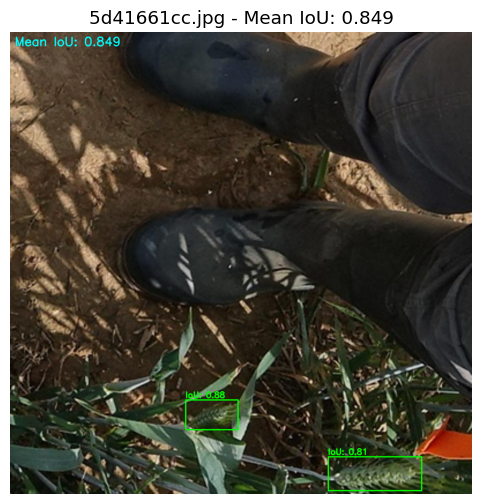

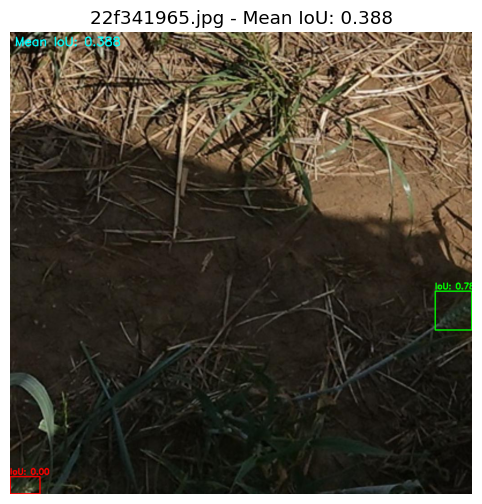

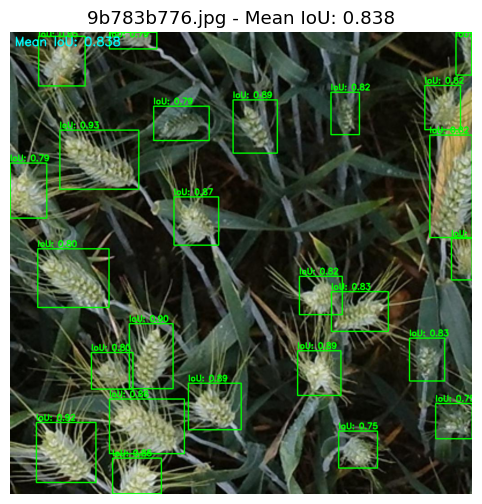

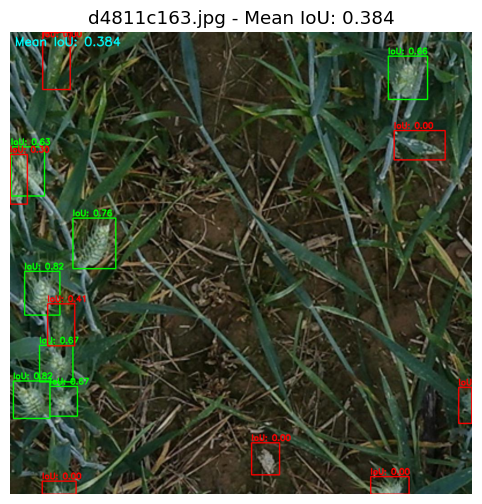

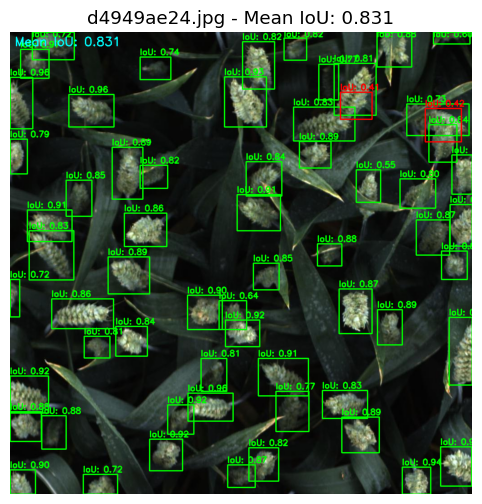

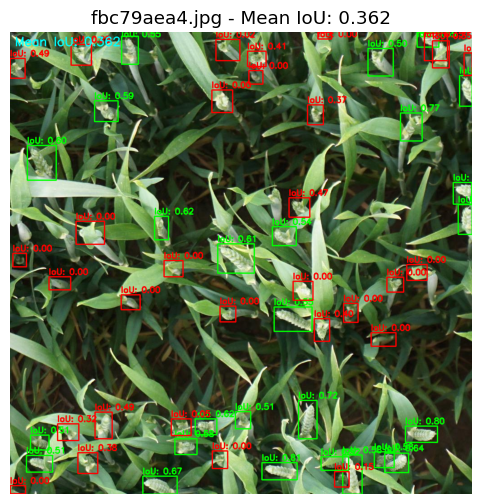

In [13]:
warnings.filterwarnings("ignore", category=FutureWarning)
#evaluate yolov5x

# path for best weights
weights_path = r"C:\Users\Ofir\yolov5\runs\train\debug_yolov5s2\weights\best.pt"




# Load model
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    model_s = torch.hub.load("ultralytics/yolov5", "custom", path=weights_path, force_reload=True)
model_s.conf = 0.25

# Evaluate IoU
image_paths = list(Path(val_image_dir).glob("*.jpg"))
image_ious = []

# determining if there are more FP or TN
total_tp, total_fp, total_fn = 0, 0, 0



for img_path in image_paths:
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    label_path = Path(val_label_dir) / (img_path.stem + ".txt")
    gt_boxes = []
    with open(label_path) as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            gt_boxes.append([x1, y1, x2, y2])

    results = model_s(str(img_path))
    pred_df = results.pandas().xyxy[0]
    ious = []

    pred_boxes = [[int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] for _, row in pred_df.iterrows()]

    matched_gt = set()
    matched_pred = set()

    for pi, pred in enumerate(pred_boxes):
        best_iou = 0
        best_gi = -1
        for gi, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gi = gi
        if best_iou >= 0.5:
            matched_gt.add(best_gi)
            matched_pred.add(pi)

    tp = len(matched_gt)
    fp = len(pred_boxes) - len(matched_pred)
    fn = len(gt_boxes) - len(matched_gt)

    total_tp += tp
    total_fp += fp
    total_fn += fn

    
    for _, row in pred_df.iterrows():
        pred_box = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])]
        best_iou = max([compute_iou(pred_box, gt) for gt in gt_boxes]) if gt_boxes else 0
        ious.append(best_iou)

    mean_iou = np.mean(ious) if ious else 0
    image_ious.append((img_path, mean_iou))

# Sort images by IoU
image_ious.sort(key=lambda x: x[1], reverse=True)
top_images = image_ious[:3]
bottom_images = image_ious[-3:]


print(f"\n Detection Error Summary:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")


# Show good/bad couples

for good, bad in zip(top_images, bottom_images):
    show_image_with_iou(good[0],model_s)
    show_image_with_iou(bad[0],model_s)

In [82]:
#Fusing predictions

#paths to weights
best_weights_l = r"C:\Users\Ofir\yolov5\runs\train\debug_small4\weights\best.pt"
best_weights_m = r"C:\Users\Ofir\yolov5\runs\train\debug_yolov5m\weights\best.pt"
best_weights_s = r"C:\Users\Ofir\yolov5\runs\train\debug_yolov5s2\weights\best.pt"

#models

model_l = torch.hub.load("ultralytics/yolov5", "custom", path=best_weights_l, force_reload=True)
model_m = torch.hub.load("ultralytics/yolov5", "custom", path=best_weights_m,force_reload=True)
model_s = torch.hub.load("ultralytics/yolov5", "custom", path=best_weights_s,force_reload=True)
for m in [model_l, model_m, model_s]:
    m.conf = 0.2  # low threshold for post-filterinx

image_paths = list(Path(val_image_dir).glob("*.jpg"))
fused_predictions = {}


for img_path in image_paths:
    results_l = model_l(str(img_path)).pandas().xyxy[0]
    results_m = model_m(str(img_path)).pandas().xyxy[0]
    results_s = model_s(str(img_path)).pandas().xyxy[0]

    preds_l = extract_boxes_and_confidences(results_l)
    preds_m = extract_boxes_and_confidences(results_m)
    preds_s = extract_boxes_and_confidences(results_s)

    #fused = fuse_boxes_with_s_base(preds_l, preds_m, preds_s)
    fused = fuse_boxes_for_image(preds_l,preds_m,preds_s,iou_thresh = 0.75)
    fused_predictions[str(img_path)] = fused
print('fused dict is ready')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Ofir/.cache\torch\hub\master.zip
YOLOv5  2025-7-23 Python-3.8.2 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Ofir/.cache\torch\hub\master.zip
YOLOv5  2025-7-23 Python-3.8.2 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Ofir/.cache\torch\hub\master.zip
YOLOv5  2025-7-23 Python-3.8.2 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


fused dict is ready


In [83]:
mean_ious = evaluate_fused_predictions(fused_predictions, val_label_dir, iou_threshold=0.5)


Fusion Evaluation Metrics:
  Precision: 0.8515
  Recall:    0.9173
  TP: 26989 | FP: 4706 | FN: 2433


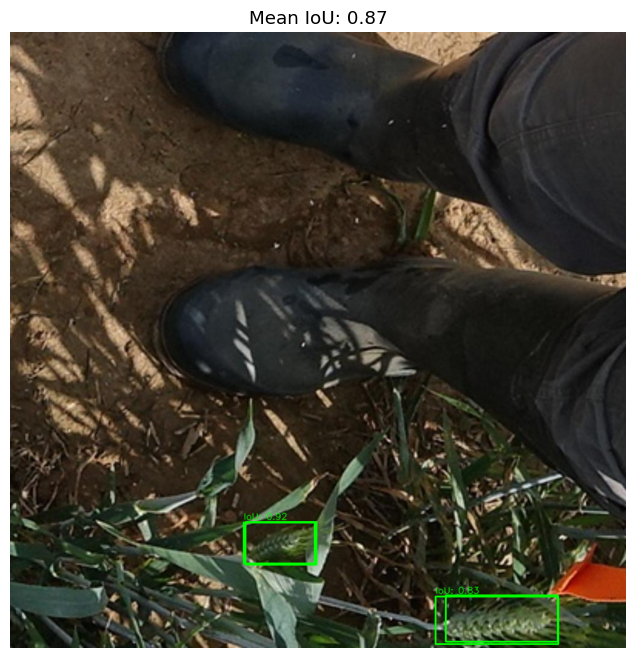

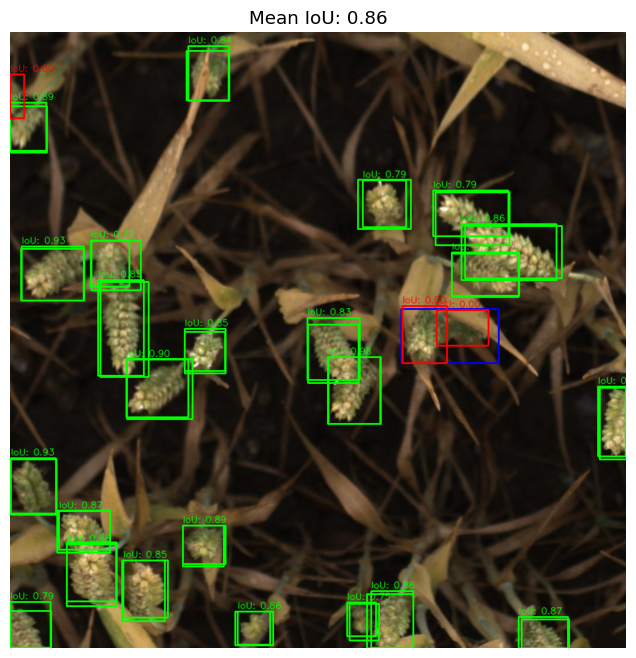

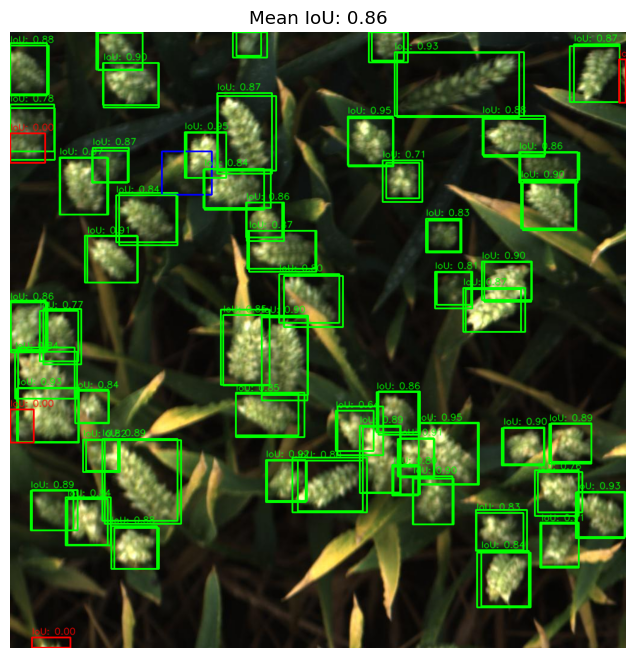

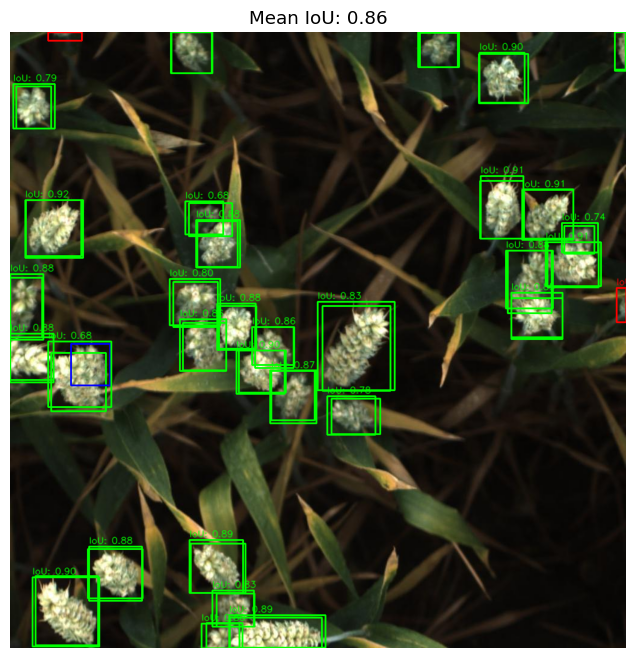

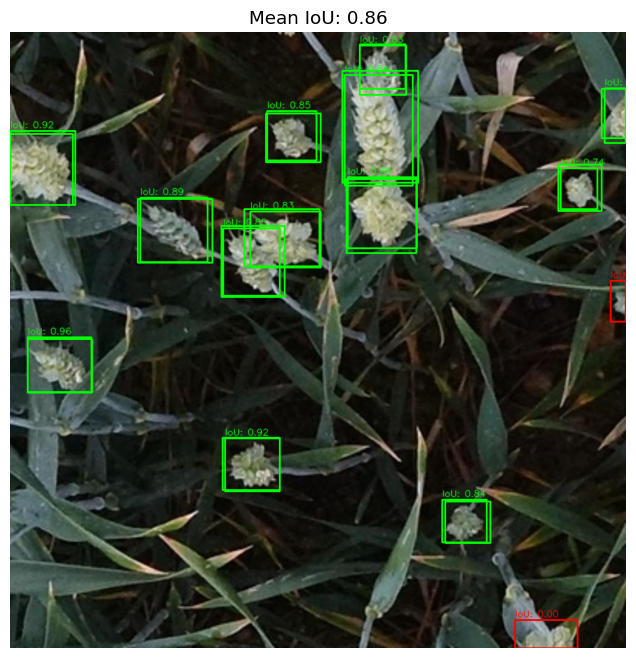

In [87]:
#visualization of few examples


iou_threshold = 0.5
N = 5  # Show top-N images

# Sort and take top N
subset_ious = sorted(mean_ious, key=lambda x: x[1], reverse=True)[:N]

for img_path, mean_iou in subset_ious:
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Load predictions
    pred_boxes = fused_predictions[str(img_path)]  # list of (box, conf)

    # Load GT boxes
    label_path = Path(label_dir) / (Path(img_path).stem + ".txt")
    gt_boxes = []
    with open(label_path) as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            gt_boxes.append([x1, y1, x2, y2])

    # Matching and draw GT boxes
    matched_gt = set()
    matched_pred = set()
    pred_ious = [0] * len(pred_boxes)  # IoU per prediction

    for pi, (pred_box, _) in enumerate(pred_boxes):
        best_iou = 0
        best_gi = -1
        for gi, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gi = gi
        if best_iou >= iou_threshold:
            matched_gt.add(best_gi)
            matched_pred.add(pi)
            pred_ious[pi] = best_iou

    # Draw GT boxes
    for gi, gt_box in enumerate(gt_boxes):
        color = (0, 255, 0) if gi in matched_gt else (0, 0, 255)  # green if matched, else red
        cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color, 2)

    # Draw Predicted boxes with IoU label
    for pi, (pred_box, _) in enumerate(pred_boxes):
        color = (0, 255, 0) if pi in matched_pred else (255, 0, 0)  # green if matched, else blue
        x1, y1, x2, y2 = map(int, pred_box)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)

        # Add IoU label if available
        iou = pred_ious[pi]
        label = f"IoU: {iou:.2f}"
        cv2.putText(img_rgb, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(f"Mean IoU: {mean_iou:.2f}")
    plt.axis('off')
    plt.show()


In [102]:
#dict for 1st model - argument for example function
model_l = torch.hub.load("ultralytics/yolov5", "custom", path=best_weights_l)
model_l.conf = 0.25  # low threshold to catch all possible detections

# Directory containing validation images
image_paths = list(Path(val_image_dir).glob("*.jpg"))

# Dictionary to store predictions for each image
preds_l_dict = {}

# Run inference
for img_path in image_paths:
    results = model_l(str(img_path)).pandas().xyxy[0]
    preds = []
    for _, row in results.iterrows():
        box = [row["xmin"], row["ymin"], row["xmax"], row["ymax"]]
        conf = row["confidence"]
        preds.append((box, conf))  # <-- tuple!
    preds_l_dict[str(img_path)] = preds
print('dict is ready')

Using cache found in C:\Users\Ofir/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-7-23 Python-3.8.2 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


dict is ready


In [109]:
ious_l = evaluate_fused_predictions(preds_l_dict, label_dir)
ious_fused = evaluate_fused_predictions(fused_predictions, label_dir)

label_dir = val_label_dir
df_l = pd.DataFrame(ious_l, columns=["img_path", "iou_l"])
df_fused = pd.DataFrame(ious_fused, columns=["img_path", "iou_fused"])

df = pd.merge(df_l, df_fused, on="img_path")

df["category"] = df.apply(classify_row, axis=1) # using classify_row on all the rows of the pd

example_paths = {} #dict for shown examples
for cat in ["both_good", "both_bad", "l_good_f_bad", "f_good_l_bad"]:
    subset = df[df["category"] == cat]
    if not subset.empty:
        example_paths[cat] = subset.sample(1).iloc[0]["img_path"]
    else:
        example_paths[cat] = None


Fusion Evaluation Metrics:
  Precision: 0.8369
  Recall:    0.9118
  TP: 26827 | FP: 5228 | FN: 2595

Fusion Evaluation Metrics:
  Precision: 0.8515
  Recall:    0.9173
  TP: 26989 | FP: 4706 | FN: 2433


In [ ]:
for cat, path in example_paths.items():#gets predictions for examples and visualize them
    if path:
        preds_l = preds_l_dict[path]
        preds_f = fused_predictions[path]
        print(f"\nCategory: {cat}")
        visualize_comparison(path, preds_l, preds_f)
    else:
        print(f"No image found for category: {cat}")

In [121]:
double_dict = {}

for img_path in image_paths:
    results_l = model_l(str(img_path)).pandas().xyxy[0]
    results_m = model_m(str(img_path)).pandas().xyxy[0]
    # = model_s(str(img_path)).pandas().xyxy[0]

    preds_l = extract_boxes_and_confidences(results_l)
    preds_m = extract_boxes_and_confidences(results_m)
    #preds_s = extract_boxes_and_confidences(results_s)

    double = fuse_two_models(preds_l,preds_m,iou_thresh = 0.75)
    double_dict[str(img_path)] = double
print('fused dict is ready')

fused dict is ready


In [133]:
ious_l = evaluate_fused_predictions(preds_l_dict, label_dir)
ious_double = evaluate_fused_predictions(double_dict, label_dir)

label_dir = val_label_dir
df_l = pd.DataFrame(ious_l, columns=["img_path", "iou_l"])
df_fused = pd.DataFrame(ious_double, columns=["img_path", "iou_fused"])

df = pd.merge(df_l, df_fused, on="img_path")

df["category"] = df.apply(classify_row, axis=1) # using classify_row on all the rows of the pd

example_paths = {} #dict for shown examples
for cat in ["both_good", "both_bad", "l_good_f_bad", "f_good_l_bad"]:
    subset = df[df["category"] == cat]
    if not subset.empty:
        example_paths[cat] = subset.sample(1).iloc[0]["img_path"]
    else:
        example_paths[cat] = None


Fusion Evaluation Metrics:
  Precision: 0.8369
  Recall:    0.9118
  TP: 26827 | FP: 5228 | FN: 2595

Fusion Evaluation Metrics:
  Precision: 0.8930
  Recall:    0.8877
  TP: 26117 | FP: 3130 | FN: 3305



Category: both_good


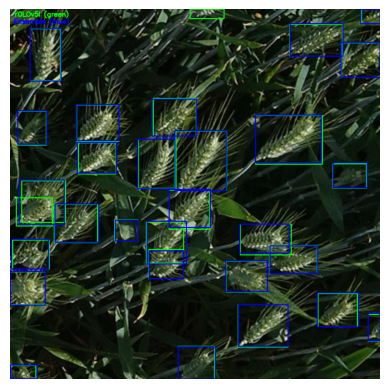

No image found for category: both_bad
No image found for category: l_good_f_bad
No image found for category: f_good_l_bad


In [134]:
for cat, path in example_paths.items():#gets predictions for examples and visualize them
    if path:
        preds_l = preds_l_dict[path]
        preds_f = double_dict[path]
        print(f"\nCategory: {cat}")
        visualize_comparison(path, preds_l, preds_f)
    else:
        print(f"No image found for category: {cat}")